# Classificação Top 200

## Objetivo do Notebook

Prever se uma música entrará ou não no Top 200 Global do Spotify Charts

## Dados a serem utilizados

São duas as bases de dados utilizadas de forma combinada para este problema:
1. Músicas que apareceram pelo menos uma vez no Top 200 Global nos últimos anos
2. Músicas que não apareceram no Top 200 Global

## Modelos Implementados

São **n** os modelos de classificação implementados

1. Regressão Logística
2. Random Forest


## Aperfeiçoamentos Implementados

Foi realizada uma busca de hiperparametros para selecionar a melhor combinacao possível de parametros para cada modelo.

Além disso, foi realizada seleção de variáveis com PCA (Principal Component Analysis) e RFE (Recursive Feature Elimination). Além disso, com o resultado do REF, foram treinados modelos sem variáveis importantes sobre o artista.

## Importação das bibliotecas necessárias

In [ ]:
#Utilidades
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Pre-processamento
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score,auc,precision_score,recall_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from google.colab import drive
drive.mount('/content/drive')

import random
random.seed(0)
np.random.seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Obtenção dos dados

In [ ]:
path_dados_consolidados = '/content/drive/My Drive/INF1032 - Spotify/Dados/Consolidados/'
dados = pd.read_csv(path_dados_consolidados+"dataset_previsao_charts.csv",index_col="Unnamed: 0")
print("Quantidade de músicas: ",dados.shape[0])
print("Variáveis disponíveis:",dados.columns.values)
dados = dados.reset_index(drop=True)
print("Qtd musicas repetidas = ",dados.duplicated().sum())
dados.head()

Quantidade de músicas:  8160
Variáveis disponíveis: ['danceability' 'energy' 'key' 'loudness' 'mode' 'speechiness'
 'acousticness' 'instrumentalness' 'liveness' 'valence' 'tempo' 'type'
 'id' 'uri' 'track_href' 'analysis_url' 'duration_ms' 'time_signature'
 'nome' 'data_lancamento' 'Popularidade Musica' 'Artista' 'ano_lancamento'
 'mes_lancamento' 'dia_semana_lancamento' 'Popularidade Artista'
 'Seguidores' 'Estilos' 'Top']
Qtd musicas repetidas =  0


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,data_lancamento,Popularidade Musica,Artista,ano_lancamento,mes_lancamento,dia_semana_lancamento,Popularidade Artista,Seguidores,Estilos,Top
0,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,0.662,...,2022-03-31,100,Harry Styles,2022.0,3.0,3.0,94,21444145,['pop'],1
1,0.905,0.563,8,-6.135,1,0.1020,0.0254,0.000010,0.1130,0.324,...,2022-04-08,94,Jack Harlow,2022.0,4.0,4.0,86,2247792,"['deep underground hip hop', 'kentucky hip hop...",1
2,0.761,0.525,11,-6.900,1,0.0944,0.4400,0.000007,0.0921,0.531,...,2020-08-06,90,Glass Animals,2020.0,8.0,3.0,80,2960684,"['gauze pop', 'indietronica', 'shiver pop']",1
3,0.591,0.764,1,-5.484,1,0.0483,0.0383,0.000000,0.1030,0.478,...,2021-07-23,88,The Kid LAROI,2021.0,7.0,4.0,83,3778109,['australian hip hop'],1
4,0.756,0.697,8,-6.377,1,0.0401,0.1820,0.000000,0.3330,0.956,...,2022-04-07,85,Camila Cabello,2022.0,4.0,3.0,83,27026106,"['dance pop', 'pop', 'post-teen pop']",1


In [ ]:
dados.tail()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,data_lancamento,Popularidade Musica,Artista,ano_lancamento,mes_lancamento,dia_semana_lancamento,Popularidade Artista,Seguidores,Estilos,Top
8155,0.609,0.777,9,-7.712,1,0.0636,0.01480,0.074600,0.1530,0.546,...,2021-10-15,50,Remi Wolf,2021.0,10.0,4.0,65,283640,"['indie pop', 'modern alternative pop']",0
8156,0.631,0.932,5,-4.142,1,0.0354,0.04360,0.137000,0.0918,0.971,...,1981-08-24,0,The Rolling Stones,1981.0,8.0,0.0,77,11805172,"['british invasion', 'classic rock', 'rock']",0
8157,0.481,0.435,4,-8.795,1,0.0321,0.67800,0.000000,0.0928,0.107,...,2014-01-01,60,Taylor Swift,2014.0,1.0,2.0,92,54364596,['pop'],0
8158,0.522,0.889,1,-4.137,1,0.0461,0.00328,0.000000,0.3450,0.852,...,2006-01-29,60,Arctic Monkeys,2006.0,1.0,6.0,82,14770606,"['garage rock', 'permanent wave', 'rock', 'she...",0
8159,0.613,0.589,0,-10.388,1,0.0458,0.10700,0.000036,0.1140,0.757,...,2000-01-01,50,Yusuf / Cat Stevens,2000.0,1.0,5.0,67,1532558,"['british folk', 'classic rock', 'folk', 'folk...",0


## Label do grupo para classificação

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


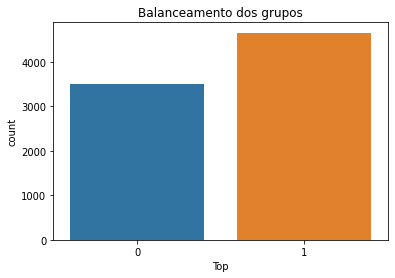

In [ ]:
plt.figure()
plt.title("Balanceamento dos grupos")
sns.countplot(dados.Top)
plt.show()

## Selecionando apenas as features úteis

In [ ]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'nome', 'data_lancamento', 'Popularidade Musica',
       'Artista', 'ano_lancamento', 'mes_lancamento', 'dia_semana_lancamento','Popularidade Artista','Estilos','Seguidores',
       'Top']

dados = dados[features]
print(dados.columns.values)

['danceability' 'energy' 'key' 'loudness' 'mode' 'speechiness'
 'acousticness' 'instrumentalness' 'liveness' 'valence' 'tempo'
 'duration_ms' 'time_signature' 'nome' 'data_lancamento'
 'Popularidade Musica' 'Artista' 'ano_lancamento' 'mes_lancamento'
 'dia_semana_lancamento' 'Popularidade Artista' 'Estilos' 'Seguidores'
 'Top']


## Analisando as variáveis

In [ ]:
dados.isna().sum()
dados = dados.dropna()
dados.isna().sum()

danceability             0
energy                   0
key                      0
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness         0
liveness                 0
valence                  0
tempo                    0
duration_ms              0
time_signature           0
nome                     0
data_lancamento          0
Popularidade Musica      0
Artista                  0
ano_lancamento           0
mes_lancamento           0
dia_semana_lancamento    0
Popularidade Artista     0
Estilos                  0
Seguidores               0
Top                      0
dtype: int64

In [ ]:
dados.dtypes

danceability             float64
energy                   float64
key                        int64
loudness                 float64
mode                       int64
speechiness              float64
acousticness             float64
instrumentalness         float64
liveness                 float64
valence                  float64
tempo                    float64
duration_ms                int64
time_signature             int64
nome                      object
data_lancamento           object
Popularidade Musica        int64
Artista                   object
ano_lancamento           float64
mes_lancamento           float64
dia_semana_lancamento    float64
Popularidade Artista       int64
Estilos                   object
Seguidores                 int64
Top                        int64
dtype: object

### Comentários:

Artista, Estilos, Nome da Música e Data Lançamento são objetos.

Para data usaremos a outras features que contém informação da data.

Nome da música e artista deixaremos de fora.

Precisamos analisar melhor as variáveis **key** e **mode**.

Popularidade da música será retirada.

In [ ]:
dados = dados.drop(columns=["Artista","data_lancamento","Popularidade Musica"],axis=1)
dados.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'nome', 'ano_lancamento',
       'mes_lancamento', 'dia_semana_lancamento', 'Popularidade Artista',
       'Estilos', 'Seguidores', 'Top'],
      dtype='object')

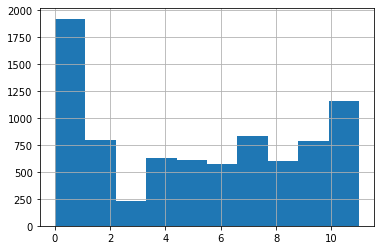

In [ ]:
dados.key.hist()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


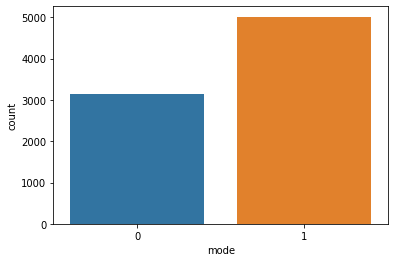

In [ ]:
sns.countplot(dados["mode"])

### Comentários:

Mode é uma variáveis binária, não precisamos fazer nada.

Key, por sua vez, é uma variável aparentemente categórica. Vamos aplicar um One Hot Encoding nela, via pd.get_dummines()

## Adequação das variáveis

In [ ]:
dummies_key = pd.get_dummies(dados.key,drop_first=True)
dummies_key.rename(columns = {1:'key1',2:'key2',
                              3:'key3',4:'key4',
                              5:'key5',6:'key6',
                              7:'key7',8:'key8',
                              9:'key9',10:'key10',
                              11:'key11',0:'key0'}, inplace = True)

dummies_key

,key1,key2,key3,key4,key5,key6,key7,key8,key9,key10,key11
0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8155,0,0,0,0,0,0,0,0,1,0,0
8156,0,0,0,0,1,0,0,0,0,0,0
8157,0,0,0,1,0,0,0,0,0,0,0
8158,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
dados = dados.drop(columns=["key"])
dados = pd.concat([dados,dummies_key],axis=1)
dados

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,key2,key3,key4,key5,key6,key7,key8,key9,key10,key11
0,0.520,0.731,-5.338,0,0.0557,0.34200,0.001010,0.3110,0.662,173.930,...,0,0,0,0,1,0,0,0,0,0
1,0.905,0.563,-6.135,1,0.1020,0.02540,0.000010,0.1130,0.324,106.998,...,0,0,0,0,0,0,1,0,0,0
2,0.761,0.525,-6.900,1,0.0944,0.44000,0.000007,0.0921,0.531,80.870,...,0,0,0,0,0,0,0,0,0,1
3,0.591,0.764,-5.484,1,0.0483,0.03830,0.000000,0.1030,0.478,169.928,...,0,0,0,0,0,0,0,0,0,0
4,0.756,0.697,-6.377,1,0.0401,0.18200,0.000000,0.3330,0.956,94.996,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8155,0.609,0.777,-7.712,1,0.0636,0.01480,0.074600,0.1530,0.546,164.024,...,0,0,0,0,0,0,0,1,0,0
8156,0.631,0.932,-4.142,1,0.0354,0.04360,0.137000,0.0918,0.971,122.429,...,0,0,0,1,0,0,0,0,0,0
8157,0.481,0.435,-8.795,1,0.0321,0.67800,0.000000,0.0928,0.107,143.950,...,0,0,1,0,0,0,0,0,0,0
8158,0.522,0.889,-4.137,1,0.0461,0.00328,0.000000,0.3450,0.852,144.499,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dummies_mes_lancamento = pd.get_dummies(dados.mes_lancamento,drop_first=True)
dummies_mes_lancamento.rename(columns = {1:'jan',2:'fev',
                              3:'mar',4:'abr',
                              5:'mai',6:'jun',
                              7:'jul',8:'ago',
                              9:'set',10:'out',
                              11:'nov',12:'dez'}, inplace = True)

dummies_mes_lancamento

,fev,mar,abr,mai,jun,jul,ago,set,out,nov,dez
0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8155,0,0,0,0,0,0,0,0,1,0,0
8156,0,0,0,0,0,0,1,0,0,0,0
8157,0,0,0,0,0,0,0,0,0,0,0
8158,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
dados = dados.drop(columns=["mes_lancamento"])
dados = pd.concat([dados,dummies_mes_lancamento],axis=1)
dados

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,mar,abr,mai,jun,jul,ago,set,out,nov,dez
0,0.520,0.731,-5.338,0,0.0557,0.34200,0.001010,0.3110,0.662,173.930,...,1,0,0,0,0,0,0,0,0,0
1,0.905,0.563,-6.135,1,0.1020,0.02540,0.000010,0.1130,0.324,106.998,...,0,1,0,0,0,0,0,0,0,0
2,0.761,0.525,-6.900,1,0.0944,0.44000,0.000007,0.0921,0.531,80.870,...,0,0,0,0,0,1,0,0,0,0
3,0.591,0.764,-5.484,1,0.0483,0.03830,0.000000,0.1030,0.478,169.928,...,0,0,0,0,1,0,0,0,0,0
4,0.756,0.697,-6.377,1,0.0401,0.18200,0.000000,0.3330,0.956,94.996,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8155,0.609,0.777,-7.712,1,0.0636,0.01480,0.074600,0.1530,0.546,164.024,...,0,0,0,0,0,0,0,1,0,0
8156,0.631,0.932,-4.142,1,0.0354,0.04360,0.137000,0.0918,0.971,122.429,...,0,0,0,0,0,1,0,0,0,0
8157,0.481,0.435,-8.795,1,0.0321,0.67800,0.000000,0.0928,0.107,143.950,...,0,0,0,0,0,0,0,0,0,0
8158,0.522,0.889,-4.137,1,0.0461,0.00328,0.000000,0.3450,0.852,144.499,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dummies_dia_semana = pd.get_dummies(dados.dia_semana_lancamento,drop_first=True)
dummies_dia_semana.rename(columns = {1:'ter',2:'qua',
                              3:'qui',4:'sex',
                              5:'sab',6:'dom',
                              0:'seg'}, inplace = True)

dummies_dia_semana

,ter,qua,qui,sex,sab,dom
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,0,1,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
8155,0,0,0,1,0,0
8156,0,0,0,0,0,0
8157,0,1,0,0,0,0
8158,0,0,0,0,0,1


In [ ]:
dados = dados.drop(columns=["dia_semana_lancamento"])
dados = pd.concat([dados,dummies_dia_semana],axis=1)
dados

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,set,out,nov,dez,ter,qua,qui,sex,sab,dom
0,0.520,0.731,-5.338,0,0.0557,0.34200,0.001010,0.3110,0.662,173.930,...,0,0,0,0,0,0,1,0,0,0
1,0.905,0.563,-6.135,1,0.1020,0.02540,0.000010,0.1130,0.324,106.998,...,0,0,0,0,0,0,0,1,0,0
2,0.761,0.525,-6.900,1,0.0944,0.44000,0.000007,0.0921,0.531,80.870,...,0,0,0,0,0,0,1,0,0,0
3,0.591,0.764,-5.484,1,0.0483,0.03830,0.000000,0.1030,0.478,169.928,...,0,0,0,0,0,0,0,1,0,0
4,0.756,0.697,-6.377,1,0.0401,0.18200,0.000000,0.3330,0.956,94.996,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8155,0.609,0.777,-7.712,1,0.0636,0.01480,0.074600,0.1530,0.546,164.024,...,0,1,0,0,0,0,0,1,0,0
8156,0.631,0.932,-4.142,1,0.0354,0.04360,0.137000,0.0918,0.971,122.429,...,0,0,0,0,0,0,0,0,0,0
8157,0.481,0.435,-8.795,1,0.0321,0.67800,0.000000,0.0928,0.107,143.950,...,0,0,0,0,0,1,0,0,0,0
8158,0.522,0.889,-4.137,1,0.0461,0.00328,0.000000,0.3450,0.852,144.499,...,0,0,0,0,0,0,0,0,0,1


### Variável Seguidores

In [ ]:
dados.Seguidores

0       21444145
1        2247792
2        2960684
3        3778109
4       27026106
          ...   
8155      283640
8156    11805172
8157    54364596
8158    14770606
8159     1532558
Name: Seguidores, Length: 8153, dtype: int64

In [ ]:
def normaliza(X):
  return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
  
dados.Seguidores = normaliza(dados['Seguidores'])
dados.Seguidores

0       0.217540
1       0.022803
2       0.030035
3       0.038327
4       0.274166
          ...   
8155    0.002877
8156    0.119757
8157    0.551501
8158    0.149840
8159    0.015547
Name: Seguidores, Length: 8153, dtype: float64

### Variável Estilos

In [ ]:
estilos = []
for estilo in dados.Estilos:
  print(estilo)
estilos

Streaming output truncated to the last 5000 lines.
['canadian contemporary r&b', 'canadian pop', 'pop']
['canadian contemporary r&b', 'canadian pop', 'pop']
['latin', 'reggaeton', 'reggaeton colombiano', 'trap latino']
['canadian contemporary r&b', 'canadian pop', 'pop']
['canadian contemporary r&b', 'canadian pop', 'pop']
['canadian contemporary r&b', 'canadian pop', 'pop']
['latin', 'reggaeton', 'reggaeton colombiano', 'trap latino']
['canadian contemporary r&b', 'canadian pop', 'pop']
['canadian contemporary r&b', 'canadian pop', 'pop']
['latin', 'reggaeton', 'reggaeton colombiano', 'trap latino']
['canadian contemporary r&b', 'canadian pop', 'pop']
['canadian contemporary r&b', 'canadian pop', 'pop']
['canadian contemporary r&b', 'canadian pop', 'pop']
['canadian contemporary r&b', 'canadian pop', 'pop']
['latin', 'reggaeton', 'reggaeton colombiano', 'trap latino']
['dance pop', 'houston rap', 'pop', 'trap queen']
['canadian contemporary r&b', 'canadian pop', 'pop']
['viral rap']
[

[]

In [ ]:
#Por enquanto vamos ignorar estilos musicas
dados = dados.drop(columns=["Estilos"])

## Separação teste treino

In [ ]:
y = dados.Top
X = dados.drop(columns=["Top","nome"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5462, 43)
(2691, 43)
(5462,)
(2691,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


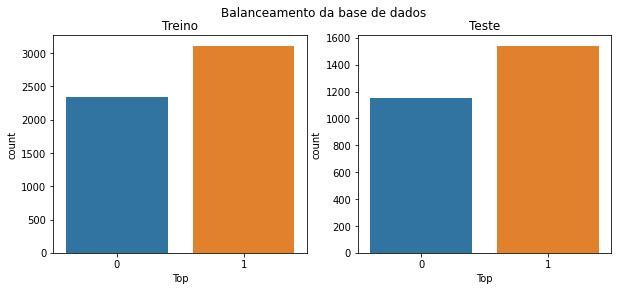

In [ ]:
plt.figure(figsize=(10,4))
plt.suptitle("Balanceamento da base de dados")
plt.subplot(1,2,1)
plt.title("Treino")
sns.countplot(y_train)
plt.subplot(1,2,2)
plt.title("Teste")
sns.countplot(y_test)
plt.show()

## Implementando os modelos

### Técnicas a serem utilizadas

Vamos implementar os modelos com *Grid Search Cross Validation* para sermos capazes de escolher a melhor combinação de hiperparametros.

In [ ]:
#Escolhendo os hiper-parametros para busca

params_logist = {'random_state':[0],
                 'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                 'max_iter':[10,50,100,200]}

params_rf = {'n_estimators':[10,50,100,200],
             'criterion':['gini', 'entropy', 'log_loss'],
             'max_depth': [None,5,10,20,50],
             'bootstrap':[False,True],
             'random_state':[0],
             'max_samples':[10,20,50,100]}


rf = RandomForestClassifier()
logreg = LogisticRegression()

### Treinando os modelos com busca de hiperparametros

In [ ]:
grid_logreg = GridSearchCV(logreg,
                    param_grid=params_logist,
                    scoring='accuracy').fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to c

In [ ]:
grid_rf = GridSearchCV(rf,
                    param_grid=params_rf,
                    scoring='accuracy').fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1600 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 380, in fit
    "`max_sample` cannot be set if `bootstrap=False`. "
ValueError: `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`.

----------------------------------------

In [ ]:
melhor_logreg = grid_logreg.best_estimator_
melhor_rf = grid_rf.best_estimator_

print("Melhores modelos")
print(melhor_logreg)
print(melhor_rf)

Melhores modelos
LogisticRegression(max_iter=200, random_state=0, solver='newton-cg')
RandomForestClassifier(max_samples=100, n_estimators=200, random_state=0)


### Previsão com os melhores modelos

In [ ]:
prev_logreg = melhor_logreg.predict(X_test)
prev_rf = melhor_rf.predict(X_test)

acur_logreg = accuracy_score(y_test,prev_logreg)
acur_rf = accuracy_score(y_test,prev_rf)

prec_logreg = precision_score(y_test,prev_logreg)
prec_rf = precision_score(y_test,prev_rf)

recal_logreg = recall_score(y_test,prev_logreg)
recal_rf = recall_score(y_test,prev_rf)

print("Scores de previsao\n")
print("Regressao Logistica: \nAcurácia = %.2f\nPrecisão = %.2f\nRecall = %.2f\n"%(acur_logreg,prec_logreg,recal_logreg))
print("Random Forest: \nAcurácia = %.2f\nPrecisão = %.2f\nRecall = %.2f"%(acur_rf,prec_rf,recal_rf))

resultados = pd.DataFrame(columns=["Modelo","Acuracia","Precisao","Recall"])
resultados.loc[len(resultados.index)] = ["Logistic Regression",acur_logreg,prec_logreg,recal_logreg]
resultados.loc[len(resultados.index)] = ["Random Forest",acur_rf,prec_rf,recal_rf]
resultados.to_csv(path_dados_consolidados+"resultados_geral.csv")

Scores de previsao

Regressao Logistica: 
Acurácia = 0.87
Precisão = 0.85
Recall = 0.93

Random Forest: 
Acurácia = 0.89
Precisão = 0.91
Recall = 0.91


### Matriz de Confusão

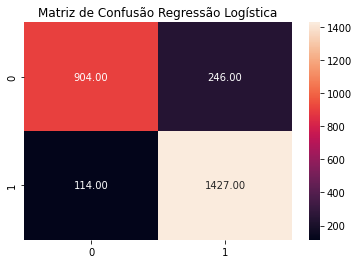

In [ ]:
cm_logreg = confusion_matrix(y_test,prev_logreg)
cm_rf = confusion_matrix(y_test,prev_rf)

plt.figure()
plt.title("Matriz de Confusão Regressão Logística")
sns.heatmap(cm_logreg,annot=True,fmt=".2f")
plt.savefig(path_dados_consolidados+"matrizconfusao_logreg_geral.png")
plt.show()

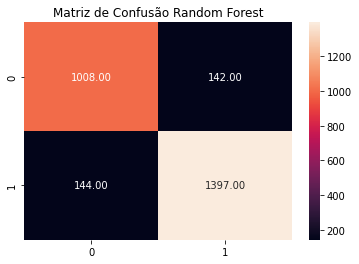

In [ ]:
plt.figure()
plt.title("Matriz de Confusão Random Forest")
sns.heatmap(cm_rf,annot=True,fmt=".2f")
plt.savefig(path_dados_consolidados+"matrizconfusao_rf_geral.png")
plt.show()

## Importância de variáveis

In [ ]:
importancia_logreg = permutation_importance(melhor_logreg, X, y, n_repeats=10,random_state=0)
importancia_rf = permutation_importance(melhor_rf, X, y, n_repeats=10,random_state=0)

In [ ]:
df_importancias_rf = pd.DataFrame(columns=["Variavel","Mean","Std"])
df_importancias_rf["Variavel"] = X.columns
df_importancias_rf["Mean"] = importancia_rf.importances_mean
df_importancias_rf["Std"] = importancia_rf.importances_std
df_importancias_rf = df_importancias_rf.sort_values(by="Mean",ascending=False)
df_importancias_rf.to_csv(path_dados_consolidados+"importancia_varivaeis_rf_geral.csv")
df_importancias_rf

,Variavel,Mean,Std
12,ano_lancamento,1.410278e-01,0.001701
13,Popularidade Artista,3.884460e-02,0.001925
14,Seguidores,1.410524e-02,0.001303
4,speechiness,8.389550e-03,0.001127
0,danceability,7.813075e-03,0.001331
6,instrumentalness,6.709187e-03,0.000774
9,tempo,2.072857e-03,0.000582
2,loudness,1.741690e-03,0.001716
5,acousticness,1.324666e-03,0.000387
1,energy,1.140684e-03,0.000738


In [ ]:
df_importancias_logreg = pd.DataFrame(columns=["Variavel","Mean","Std"])
df_importancias_logreg["Variavel"] = X.columns
df_importancias_logreg["Mean"] = importancia_logreg.importances_mean
df_importancias_logreg["Std"] = importancia_logreg.importances_std
df_importancias_logreg = df_importancias_logreg.sort_values(by="Mean",ascending=False)
df_importancias_logreg.to_csv(path_dados_consolidados+"importancia_varivaeis_logreg_geral.csv")
df_importancias_logreg

,Variavel,Mean,Std
13,Popularidade Artista,0.113455,0.003189
12,ano_lancamento,0.048510,0.002517
40,sex,0.018815,0.001735
0,danceability,0.016374,0.001700
39,qui,0.013750,0.001119
6,instrumentalness,0.012449,0.001843
2,loudness,0.009714,0.002087
4,speechiness,0.008058,0.001231
10,duration_ms,0.006660,0.001775
1,energy,0.004918,0.001484


## Agora apenas com as informações técnicas de cada música, excluindo variáveis sobre o artista 

In [ ]:
#Selecionando as variaveis de entrada
dados_sem_artista = dados.drop(columns=["Seguidores","Popularidade Artista"])

y = dados_sem_artista.Top
X = dados_sem_artista.drop(columns=["Top","nome"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5462, 41)
(2691, 41)
(5462,)
(2691,)


In [ ]:
#Treinando os modelos
grid_logreg = GridSearchCV(logreg,
                    param_grid=params_logist,
                    scoring='accuracy').fit(X_train, y_train)

grid_rf = GridSearchCV(rf,
                    param_grid=params_rf,
                    scoring='accuracy').fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/op

In [ ]:
#Selecionando o melhor modelo do Grid Search
melhor_logreg = grid_logreg.best_estimator_
melhor_rf = grid_rf.best_estimator_

print("Melhores modelos")
print(melhor_logreg)
print(melhor_rf)

#Previsão dos modelos
prev_logreg = melhor_logreg.predict(X_test)
prev_rf = melhor_rf.predict(X_test)

acur_logreg = accuracy_score(y_test,prev_logreg)
acur_rf = accuracy_score(y_test,prev_rf)

prec_logreg = precision_score(y_test,prev_logreg)
prec_rf = precision_score(y_test,prev_rf)

recal_logreg = recall_score(y_test,prev_logreg)
recal_rf = recall_score(y_test,prev_rf)

print("Scores de previsao\n")
print("Regressao Logistica: \nAcurácia = %.2f\nPrecisão = %.2f\nRecall = %.2f\n"%(acur_logreg,prec_logreg,recal_logreg))
print("Random Forest: \nAcurácia = %.2f\nPrecisão = %.2f\nRecall = %.2f"%(acur_rf,prec_rf,recal_rf))

resultados = pd.DataFrame(columns=["Modelo","Acuracia","Precisao","Recall"])
resultados.loc[len(resultados.index)] = ["Logistic Regression",acur_logreg,prec_logreg,recal_logreg]
resultados.loc[len(resultados.index)] = ["Random Forest",acur_rf,prec_rf,recal_rf]
resultados.to_csv(path_dados_consolidados+"resultados_semArtista.csv")

Melhores modelos
LogisticRegression(max_iter=200, random_state=0, solver='newton-cg')
RandomForestClassifier(criterion='entropy', max_depth=10, max_samples=100,
                       n_estimators=200, random_state=0)
Scores de previsao

Regressao Logistica: 
Acurácia = 0.83
Precisão = 0.81
Recall = 0.93

Random Forest: 
Acurácia = 0.85
Precisão = 0.85
Recall = 0.90


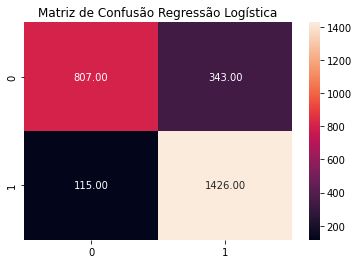

In [ ]:
#Matriz de confusao
cm_logreg = confusion_matrix(y_test,prev_logreg)
cm_rf = confusion_matrix(y_test,prev_rf)

plt.figure()
plt.title("Matriz de Confusão Regressão Logística")
sns.heatmap(cm_logreg,annot=True,fmt=".2f")
plt.savefig(path_dados_consolidados+"matrizconfusao_logreg_semArtista.png")
plt.show()

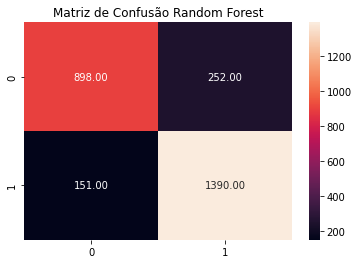

In [ ]:
plt.figure()
plt.title("Matriz de Confusão Random Forest")
sns.heatmap(cm_rf,annot=True,fmt=".2f")
plt.savefig(path_dados_consolidados+"matrizconfusao_rf_semArtista.png")
plt.show()

In [ ]:
importancia_logreg = permutation_importance(melhor_logreg, X, y, n_repeats=10,random_state=0)
importancia_rf = permutation_importance(melhor_rf, X, y, n_repeats=10,random_state=0)

In [ ]:
df_importancias_rf = pd.DataFrame(columns=["Variavel","Mean","Std"])
df_importancias_rf["Variavel"] = X.columns
df_importancias_rf["Mean"] = importancia_rf.importances_mean
df_importancias_rf["Std"] = importancia_rf.importances_std
df_importancias_rf = df_importancias_rf.sort_values(by="Mean",ascending=False)
df_importancias_rf.to_csv(path_dados_consolidados+"importancia_varivaeis_rf_semArtista.csv")
df_importancias_rf

,Variavel,Mean,Std
12,ano_lancamento,2.016436e-01,0.003440
6,instrumentalness,1.090396e-02,0.001296
4,speechiness,5.237336e-03,0.001670
2,loudness,4.587268e-03,0.001262
0,danceability,3.618300e-03,0.000688
1,energy,3.225806e-03,0.001071
9,tempo,2.391758e-03,0.000883
5,acousticness,1.741690e-03,0.001001
10,duration_ms,1.692628e-03,0.000872
7,liveness,1.214277e-03,0.000743


In [ ]:
df_importancias_logreg = pd.DataFrame(columns=["Variavel","Mean","Std"])
df_importancias_logreg["Variavel"] = X.columns
df_importancias_logreg["Mean"] = importancia_logreg.importances_mean
df_importancias_logreg["Std"] = importancia_logreg.importances_std
df_importancias_logreg = df_importancias_logreg.sort_values(by="Mean",ascending=False)
df_importancias_logreg.to_csv(path_dados_consolidados+"importancia_varivaeis_logreg_semArtista.csv")
df_importancias_logreg

,Variavel,Mean,Std
12,ano_lancamento,6.614743e-02,0.003000
2,loudness,4.411873e-02,0.002900
6,instrumentalness,3.261376e-02,0.001583
38,sex,2.818594e-02,0.001697
37,qui,2.038513e-02,0.001177
0,danceability,2.023795e-02,0.002007
1,energy,1.351650e-02,0.002070
4,speechiness,9.468907e-03,0.001881
10,duration_ms,4.758984e-03,0.001601
36,qua,4.047590e-03,0.000593


## Implementação dos modelos utilizando PCA

Vou aplicar o PCA para redução de dimensionalidade apenas nos dados que não foram separados em dummies

In [ ]:
dados.columns

Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'ano_lancamento',
       'Popularidade Artista', 'Seguidores', 'Top', 'key1', 'key2', 'key3',
       'key4', 'key5', 'key6', 'key7', 'key8', 'key9', 'key10', 'key11', 'fev',
       'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez',
       'ter', 'qua', 'qui', 'sex', 'sab', 'dom'],
      dtype='object')

In [ ]:
print(dados.shape)
dados_semDummies = dados[['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'ano_lancamento',
       'Popularidade Artista', 'Seguidores', 'Top']]

dados_dummies = dados[['key1', 'key2', 'key3',
       'key4', 'key5', 'key6', 'key7', 'key8', 'key9', 'key10', 'key11', 'fev',
       'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez',
       'ter', 'qua', 'qui', 'sex', 'sab', 'dom']]

dados_semDummies = dados_semDummies.reset_index(drop=True)
dados_dummies = dados_dummies.reset_index(drop=True)
print(dados_semDummies.shape)
print(dados_dummies.shape)

(8153, 44)
(8153, 16)
(8153, 28)


In [ ]:
#Selecionando as variaveis de entrada
y = dados_semDummies.Top
X = dados_semDummies.drop(columns="Top")

print(X.shape)
print(y.shape)

(8153, 15)
(8153,)


In [ ]:
#Aplicando PCA
pca = PCA(copy=True,n_components=5,svd_solver="full",random_state=0).fit(X)
print(pca.explained_variance_)
print(abs(pca.components_))

[4.58071822e+09 8.69686444e+02 3.13110973e+02 1.62485140e+02
 1.29785324e+01]
[[5.36612578e-07 9.84661380e-08 3.58059899e-06 1.12198577e-08
  1.55560769e-07 1.52446130e-07 1.19571596e-07 9.99089544e-08
  4.42191847e-07 1.25891355e-05 9.99999999e-01 2.40171520e-08
  4.84831210e-05 2.54948519e-06 2.79207433e-08]
 [1.22379655e-04 1.33989498e-03 2.12931355e-02 4.05780948e-04
  4.26270155e-04 1.58742528e-03 6.33353317e-04 5.02737997e-05
  6.38098514e-04 9.98593041e-01 1.29646486e-05 9.54915560e-05
  3.99956212e-03 4.83428808e-02 1.18978782e-04]
 [2.68418179e-03 1.88714552e-03 8.60614449e-02 1.71112302e-03
  1.19671065e-03 4.02451038e-03 3.90774466e-03 2.52192628e-04
  8.65122392e-04 4.73926692e-02 2.18783587e-05 1.88596866e-03
  4.09518101e-01 9.06944294e-01 6.58576553e-03]
 [1.57483793e-03 1.33050373e-04 3.94091614e-02 3.08664923e-03
  6.74217175e-04 8.39840046e-06 1.62989654e-03 4.27541171e-04
  2.97134237e-03 1.55432673e-02 4.33761800e-05 2.58147523e-04
  9.09467654e-01 4.13576354e-01 2.

In [ ]:
X_pca = pca.transform(X)
print(X_pca.shape)

(8153, 5)


In [ ]:
X_pca_completo = pd.DataFrame(X_pca)
X_pca_completo = X_pca_completo.reset_index(drop=True)
# print(X_pca_completo.shape)
# print(dados_dummies.shape)
X_pca_completo = pd.concat([X_pca_completo,dados_dummies],axis=1)
# print(X_pca_completo.shape)
# print(X_pca_completo.shape)
X_pca_completo.rename(columns = {1:'pca1',2:'pca2',
                              3:'pca3',4:'pca4',
                              0:'pca0'}, inplace = True)
X_pca_completo

,pca0,pca1,pca2,pca3,pca4,key1,key2,key3,key4,key5,...,set,out,nov,dez,ter,qua,qui,sex,sab,dom
0,-48770.760761,-52.745448,-22.011202,1.478583,0.945992,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,-42125.759903,14.409537,-18.003923,-1.045578,0.022111,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,22731.240458,39.974837,-14.332362,-4.084236,-0.176133,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,-74267.760601,-47.880410,-11.243355,-0.985392,0.228485,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,-10002.759785,26.128002,-16.534070,-3.480805,-0.147549,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8148,-49755.760504,-41.384947,4.457710,-9.313441,1.199315,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
8149,-3006.758144,-0.951092,6.653398,30.507602,-5.187711,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8150,34019.239917,-23.677825,-19.854779,4.940361,3.203812,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8151,-74940.759555,-22.399303,-5.500526,12.615976,-2.715516,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_completo, y, test_size=0.33, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5462, 33)
(2691, 33)
(5462,)
(2691,)


In [ ]:
#Treinando os modelos
grid_logreg = GridSearchCV(logreg,
                    param_grid=params_logist,
                    scoring='accuracy').fit(X_train, y_train)

grid_rf = GridSearchCV(rf,
                    param_grid=params_rf,
                    scoring='accuracy').fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to c

In [ ]:
#Selecionando o melhor modelo do Grid Search
melhor_logreg = grid_logreg.best_estimator_
melhor_rf = grid_rf.best_estimator_

print("Melhores modelos")
print(melhor_logreg)
print(melhor_rf)

#Previsão dos modelos
prev_logreg = melhor_logreg.predict(X_test)
prev_rf = melhor_rf.predict(X_test)

acur_logreg = accuracy_score(y_test,prev_logreg)
acur_rf = accuracy_score(y_test,prev_rf)

prec_logreg = precision_score(y_test,prev_logreg)
prec_rf = precision_score(y_test,prev_rf)

recal_logreg = recall_score(y_test,prev_logreg)
recal_rf = recall_score(y_test,prev_rf)

print("Scores de previsao\n")
print("Regressao Logistica: \nAcurácia = %.2f\nPrecisão = %.2f\nRecall = %.2f\n"%(acur_logreg,prec_logreg,recal_logreg))
print("Random Forest: \nAcurácia = %.2f\nPrecisão = %.2f\nRecall = %.2f"%(acur_rf,prec_rf,recal_rf))

resultados = pd.DataFrame(columns=["Modelo","Acuracia","Precisao","Recall"])
resultados.loc[len(resultados.index)] = ["Logistic Regression",acur_logreg,prec_logreg,recal_logreg]
resultados.loc[len(resultados.index)] = ["Random Forest",acur_rf,prec_rf,recal_rf]
resultados.to_csv(path_dados_consolidados+"resultados_PCA.csv")

Melhores modelos
LogisticRegression(max_iter=200, random_state=0, solver='newton-cg')
RandomForestClassifier(criterion='entropy', max_samples=100, random_state=0)
Scores de previsao

Regressao Logistica: 
Acurácia = 0.85
Precisão = 0.84
Recall = 0.92

Random Forest: 
Acurácia = 0.86
Precisão = 0.86
Recall = 0.91


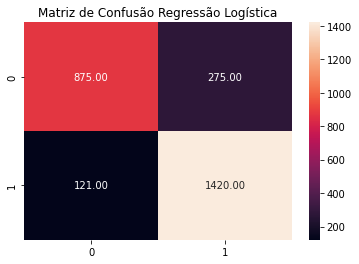

In [ ]:
#Matriz de confusao
cm_logreg = confusion_matrix(y_test,prev_logreg)
cm_rf = confusion_matrix(y_test,prev_rf)

plt.figure()
plt.title("Matriz de Confusão Regressão Logística")
sns.heatmap(cm_logreg,annot=True,fmt=".2f")
plt.savefig(path_dados_consolidados+"matrizconfusao_logreg_PCA.png")
plt.show()

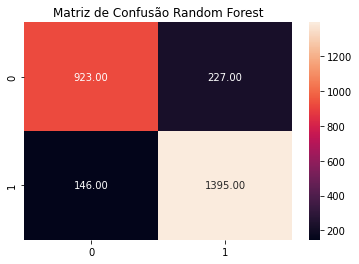

In [ ]:
plt.figure()
plt.title("Matriz de Confusão Random Forest")
sns.heatmap(cm_rf,annot=True,fmt=".2f")
plt.savefig(path_dados_consolidados+"matrizconfusao_rf_PCA.png")
plt.show()

In [ ]:
importancia_logreg = permutation_importance(melhor_logreg, X_pca_completo, y, n_repeats=10,random_state=0)
importancia_rf = permutation_importance(melhor_rf, X_pca_completo, y, n_repeats=10,random_state=0)

In [ ]:
df_importancias_rf = pd.DataFrame(columns=["Variavel","Mean","Std"])
df_importancias_rf["Variavel"] = X_pca_completo.columns
df_importancias_rf["Mean"] = importancia_rf.importances_mean
df_importancias_rf["Std"] = importancia_rf.importances_std
df_importancias_rf = df_importancias_rf.sort_values(by="Mean",ascending=False)
df_importancias_rf.to_csv(path_dados_consolidados+"importancia_varivaeis_rf_PCA.csv")
df_importancias_rf

,Variavel,Mean,Std
2,pca2,0.225475,0.004393
3,pca3,0.048841,0.001916
0,pca0,0.014154,0.001447
4,pca4,0.006219,0.001474
30,sex,0.006047,0.001032
1,pca1,0.004281,0.000592
29,qui,0.001864,0.000481
27,ter,0.001766,0.000633
25,nov,0.001545,0.000446
26,dez,0.000944,0.000258


In [ ]:
df_importancias_logreg = pd.DataFrame(columns=["Variavel","Mean","Std"])
df_importancias_logreg["Variavel"] = X_pca_completo.columns
df_importancias_logreg["Mean"] = importancia_logreg.importances_mean
df_importancias_logreg["Std"] = importancia_logreg.importances_std
df_importancias_logreg = df_importancias_logreg.sort_values(by="Mean",ascending=False)
df_importancias_logreg.to_csv(path_dados_consolidados+"importancia_varivaeis_logreg_PCA.csv")
df_importancias_logreg

,Variavel,Mean,Std
2,pca2,2.561388e-01,0.004176
0,pca0,2.787931e-02,0.001688
30,sex,2.775665e-02,0.002523
29,qui,1.810377e-02,0.001006
3,pca3,1.514780e-02,0.001498
4,pca4,5.801545e-03,0.001094
28,qua,3.017294e-03,0.000868
5,key1,2.514412e-03,0.000609
14,key10,2.256838e-03,0.000494
17,mar,1.852079e-03,0.000566


## Implementação dos modelos com remoção de anomalias

Vou aproveitar que implementamos um detector de anomalias para ver se a qualidade da previsão aumenta ao retirar as músicas que são, possivelmente, anômalas.

In [ ]:
anomalias_boas = pd.read_csv(path_dados_consolidados+"resultado_anomalias_musicas_boas.csv",index_col="Unnamed: 0")
anomalias_ruins = pd.read_csv(path_dados_consolidados+"resultado_anomalias_musicas_ruins.csv",index_col="Unnamed: 0")

anomalias_boas = anomalias_boas.drop(columns=["Unnamed: 0.1"])
anomalias_ruins = anomalias_ruins.drop(columns=["Unnamed: 0.1"])

In [ ]:
mask_boas = anomalias_boas["probabilidade"]>0.5
mask_ruins = anomalias_ruins["probabilidade"]>0.5

print(mask_boas.sum())
print(mask_ruins.sum())

22
20


In [ ]:
anomalias_ruins = anomalias_ruins[mask_ruins]
nomes_anomalias_ruins = anomalias_ruins.nome
anomalias_ruins

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,abod,prob abod,autoencoder,prob autoencoder,lof,prob lof,if,prob if,total votos,probabilidade
79,0.1840,0.00275,1,-39.619,0,0.0512,0.99500,0.93400,0.1140,0.1630,...,1,0.030771,1,0.999999,0,1.000000,1,0.999783,3,0.507638
154,0.6890,0.73500,2,-4.545,1,0.2670,0.00922,0.00072,0.3650,0.0590,...,0,0.969229,1,0.969113,1,0.793117,1,0.987032,3,0.687316
377,0.3130,0.34500,8,-13.495,1,0.0573,0.84800,0.00989,0.7250,0.2160,...,1,0.030771,1,1.000000,1,0.000000,1,0.989009,4,0.504945
726,0.3650,0.74100,9,-11.513,0,0.0516,0.00150,0.84700,0.1470,0.3090,...,1,0.030771,1,0.994146,1,0.000000,1,0.992308,4,0.504306
940,0.1280,0.37400,7,-11.184,0,0.0385,0.69500,0.91200,0.1430,0.0701,...,1,0.030771,1,0.998682,1,0.000000,1,0.981851,4,0.502826
1087,0.1660,0.94800,11,-8.503,0,0.0631,0.00374,0.01310,0.7690,0.4760,...,1,0.030771,1,0.990608,1,0.000000,1,0.989598,4,0.502744
1113,0.7260,0.71900,6,-5.122,0,0.2340,0.13700,0.00000,0.6600,0.8260,...,0,0.969229,1,0.999831,1,0.999088,1,0.996598,3,0.748879
1162,0.8250,0.65200,1,-3.183,0,0.0802,0.58100,0.00000,0.0931,0.9310,...,0,0.969230,1,0.998320,1,1.000000,1,0.969319,3,0.741910
1977,0.2120,0.24500,8,-16.939,1,0.0455,0.87500,0.00527,0.4060,0.1780,...,1,0.030771,1,0.996396,1,0.000000,1,0.988322,4,0.503872
2353,0.7950,0.37800,4,-9.979,1,0.3160,0.85900,0.00000,0.2040,0.5760,...,0,0.969229,1,0.980518,1,1.000000,1,0.977152,3,0.739417


In [ ]:
anomalias_boas = anomalias_boas[mask_boas]
nomes_anomalias_boas = anomalias_boas.nome
anomalias_boas

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,abod,prob abod,autoencoder,prob autoencoder,lof,prob lof,if,prob if,total votos,probabilidade
171,0.454,0.910,6,-7.766,1,0.0448,0.0866,0.099600,0.1160,0.6290,...,1,0.023365,1,0.969456,1,1.000000,1,0.971554,4,0.741094
309,0.271,0.551,2,-7.480,1,0.0457,0.5820,0.000042,0.2560,0.4280,...,1,0.023365,1,0.991113,0,0.909872,1,0.998930,3,0.503352
444,0.526,0.328,1,-9.864,1,0.0461,0.6940,0.000000,0.1120,0.1100,...,1,0.023365,1,0.999609,1,0.999999,1,0.987996,4,0.752742
1016,0.773,0.859,11,-4.913,1,0.0747,0.0855,0.000180,0.9140,0.8130,...,1,0.023365,1,0.999853,0,0.530942,1,0.999119,3,0.505584
1144,0.602,0.553,11,-9.336,1,0.0328,0.1080,0.000000,0.0512,0.9710,...,1,0.023365,1,0.999978,0,1.000000,1,0.998983,3,0.505581
1160,0.920,0.654,11,-3.051,0,0.0401,0.0236,0.015800,0.0359,0.8470,...,1,0.023365,1,0.987869,0,0.551385,1,0.994511,3,0.501436
1330,0.671,0.373,9,-18.064,1,0.0323,0.2570,0.000080,0.0481,0.7320,...,1,0.023365,1,0.997729,0,1.000000,1,0.996387,3,0.504370
1821,0.336,0.231,1,-6.217,1,0.0497,0.9420,0.000000,0.1880,0.4290,...,1,0.023365,1,0.963463,1,0.961607,1,0.961043,4,0.727369
1867,0.636,0.335,11,-13.327,1,0.9660,0.9930,0.000000,0.3420,0.5610,...,1,0.023365,1,0.999998,1,0.845565,1,0.999989,4,0.717229
1952,0.647,0.814,11,-16.493,0,0.9410,0.8100,0.000000,0.4450,0.0787,...,1,0.023365,1,0.999912,0,1.000000,1,0.999804,3,0.505770


In [ ]:
#Retirando as musicas anomalas dos dados
colunas_comuns = ['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'ano_lancamento', 'Popularidade Artista',
       'Seguidores']

colunas_referencia = ["nome","duration_ms","Popularidade Artista","ano_lancamento"]


anomalias_boas = anomalias_boas[colunas_referencia]
anomalias_ruins = anomalias_ruins[colunas_referencia]
dados_aux = dados[colunas_referencia]
print(anomalias_boas.shape,anomalias_ruins.shape,dados_aux.shape)

lista_indices_anomalias = []

for idx,row in anomalias_boas.iterrows():
  for idx_2,row2 in dados.iterrows():
    if row2["nome"] == row["nome"] and row2["duration_ms"] == row["duration_ms"]:
      lista_indices_anomalias.append(idx_2)
  
print(len(lista_indices_anomalias))

for idx,row in anomalias_ruins.iterrows():
  for idx_2,row2 in dados.iterrows():
    if row2["nome"] == row["nome"] and row2["duration_ms"] == row["duration_ms"]:
      lista_indices_anomalias.append(idx_2)
  
print(len(lista_indices_anomalias))

(22, 4) (20, 4) (8153, 4)
22
42


In [ ]:
nomes_anomalias = pd.concat([anomalias_boas.nome,anomalias_ruins.nome],axis=0)
nomes_anomalias.sort_values()

1330                                               Africa
2874                                            Afterglow
3261                                   Alfred - Interlude
4393    All Too Well (10 Minute Version) (Taylor's Ver...
1977    Amazing Grace - Live at New Temple Missionary ...
377     Amazing Grace - Live at New Temple Missionary ...
4163                                       Beautiful Trip
1160                                          Billie Jean
3655                                         Chromatica I
3653                                        Chromatica II
309          Fairytale of New York (feat. Kirsty MacColl)
940                                                Finale
3908                                              Forever
444                                          Give Me Love
3157                                         Give Me Love
3707                          Godzilla (feat. Juice WRLD)
1952                                    I Love You Dwayne
3523          

In [ ]:
dados.nome[lista_indices_anomalias].sort_values()

1254                                               Africa
3789                                            Afterglow
2972                                   Alfred - Interlude
3987    All Too Well (10 Minute Version) (Taylor's Ver...
6437    Amazing Grace - Live at New Temple Missionary ...
5001    Amazing Grace - Live at New Temple Missionary ...
3781                                       Beautiful Trip
1106                                          Billie Jean
3340                                         Chromatica I
3338                                        Chromatica II
306          Fairytale of New York (feat. Kirsty MacColl)
5497                                               Finale
8143                                              Forever
437                                          Give Me Love
437                                          Give Me Love
2946                          Godzilla (feat. Juice WRLD)
1820                                    I Love You Dwayne
7813          

In [ ]:
dados_sem_anomalias = dados.drop(labels=lista_indices_anomalias,axis="index")
print(dados.shape)
print(dados_sem_anomalias.shape) 
print(dados_sem_anomalias.columns)

(8153, 45)
(8112, 45)
Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'nome', 'ano_lancamento',
       'Popularidade Artista', 'Seguidores', 'Top', 'key1', 'key2', 'key3',
       'key4', 'key5', 'key6', 'key7', 'key8', 'key9', 'key10', 'key11', 'fev',
       'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez',
       'ter', 'qua', 'qui', 'sex', 'sab', 'dom'],
      dtype='object')


In [ ]:
#Selecionando as variaveis de entrada
y_sem_anomalias = dados_sem_anomalias.Top
X_sem_anomalias = dados_sem_anomalias.drop(columns=["Top","nome"])

print(X_sem_anomalias.shape)
print(y_sem_anomalias.shape)

(8112, 43)
(8112,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sem_anomalias, y_sem_anomalias, test_size=0.33, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5435, 43)
(2677, 43)
(5435,)
(2677,)


In [ ]:
#Treinando os modelos
grid_logreg = GridSearchCV(logreg,
                    param_grid=params_logist,
                    scoring='accuracy').fit(X_train, y_train)

grid_rf = GridSearchCV(rf,
                    param_grid=params_rf,
                    scoring='accuracy').fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to c

In [ ]:
#Selecionando o melhor modelo do Grid Search
melhor_logreg = grid_logreg.best_estimator_
melhor_rf = grid_rf.best_estimator_

print("Melhores modelos")
print(melhor_logreg)
print(melhor_rf)

# Previsão dos modelos
prev_logreg = melhor_logreg.predict(X_test)
prev_rf = melhor_rf.predict(X_test)

acur_logreg = accuracy_score(y_test,prev_logreg)
acur_rf = accuracy_score(y_test,prev_rf)

prec_logreg = precision_score(y_test,prev_logreg)
prec_rf = precision_score(y_test,prev_rf)

recal_logreg = recall_score(y_test,prev_logreg)
recal_rf = recall_score(y_test,prev_rf)

print("Scores de previsao\n")
print("Regressao Logistica: \nAcurácia = %.2f\nPrecisão = %.2f\nRecall = %.2f\n"%(acur_logreg,prec_logreg,recal_logreg))
print("Random Forest: \nAcurácia = %.2f\nPrecisão = %.2f\nRecall = %.2f"%(acur_rf,prec_rf,recal_rf))

resultados = pd.DataFrame(columns=["Modelo","Acuracia","Precisao","Recall"])
resultados.loc[len(resultados.index)] = ["Logistic Regression",acur_logreg,prec_logreg,recal_logreg]
resultados.loc[len(resultados.index)] = ["Random Forest",acur_rf,prec_rf,recal_rf]
resultados.to_csv(path_dados_consolidados+"resultados_semAnomalia.csv")

Melhores modelos
LogisticRegression(max_iter=200, random_state=0, solver='newton-cg')
RandomForestClassifier(criterion='entropy', max_samples=100, n_estimators=200,
                       random_state=0)
Scores de previsao

Regressao Logistica: 
Acurácia = 0.87
Precisão = 0.86
Recall = 0.93

Random Forest: 
Acurácia = 0.90
Precisão = 0.91
Recall = 0.92


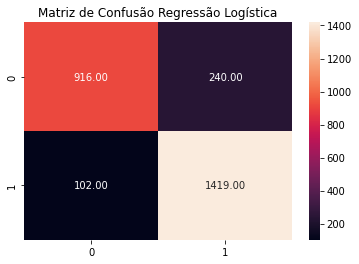

In [ ]:
#Matriz de confusao
cm_logreg = confusion_matrix(y_test,prev_logreg)
cm_rf = confusion_matrix(y_test,prev_rf)

plt.figure()
plt.title("Matriz de Confusão Regressão Logística")
sns.heatmap(cm_logreg,annot=True,fmt=".2f")
plt.savefig(path_dados_consolidados+"matrizconfusao_logreg_semAnomalia.png")
plt.show()

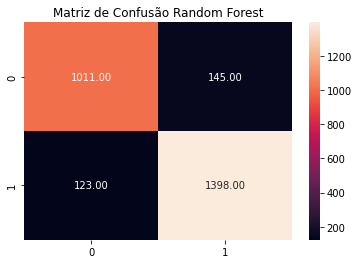

In [ ]:
plt.figure()
plt.title("Matriz de Confusão Random Forest")
sns.heatmap(cm_rf,annot=True,fmt=".2f")
plt.savefig(path_dados_consolidados+"matrizconfusao_rf_semAnomalia.png")
plt.show()

In [ ]:
importancia_logreg = permutation_importance(melhor_logreg, X_sem_anomalias, y_sem_anomalias, n_repeats=10,random_state=0)
importancia_rf = permutation_importance(melhor_rf, X_sem_anomalias, y_sem_anomalias, n_repeats=10,random_state=0)

In [ ]:
df_importancias_rf = pd.DataFrame(columns=["Variavel","Mean","Std"])
df_importancias_rf["Variavel"] = X_sem_anomalias.columns
df_importancias_rf["Mean"] = importancia_rf.importances_mean
df_importancias_rf["Std"] = importancia_rf.importances_std
df_importancias_rf = df_importancias_rf.sort_values(by="Mean",ascending=False)
df_importancias_rf.to_csv(path_dados_consolidados+"importancia_varivaeis_rf_semAnomalia.csv")
df_importancias_rf

,Variavel,Mean,Std
12,ano_lancamento,1.272806e-01,0.003216
13,Popularidade Artista,3.288955e-02,0.001345
14,Seguidores,1.931706e-02,0.001166
4,speechiness,1.012081e-02,0.001429
0,danceability,8.185404e-03,0.001631
6,instrumentalness,6.200690e-03,0.000977
1,energy,2.921598e-03,0.000578
2,loudness,1.577909e-03,0.000873
9,tempo,1.429980e-03,0.000689
5,acousticness,1.232742e-03,0.000517


In [ ]:
df_importancias_logreg = pd.DataFrame(columns=["Variavel","Mean","Std"])
df_importancias_logreg["Variavel"] = X_sem_anomalias.columns
df_importancias_logreg["Mean"] = importancia_logreg.importances_mean
df_importancias_logreg["Std"] = importancia_logreg.importances_std
df_importancias_logreg = df_importancias_logreg.sort_values(by="Mean",ascending=False)
df_importancias_logreg.to_csv(path_dados_consolidados+"importancia_varivaeis_logreg_semAnomalia.csv")
df_importancias_logreg

,Variavel,Mean,Std
13,Popularidade Artista,0.105843,0.002784
12,ano_lancamento,0.053267,0.002644
40,sex,0.020180,0.001323
0,danceability,0.020044,0.001673
39,qui,0.015212,0.000888
6,instrumentalness,0.014756,0.001502
2,loudness,0.010207,0.002377
4,speechiness,0.009825,0.001813
10,duration_ms,0.007162,0.001328
38,qua,0.004056,0.000456
